In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/DoAnCV/eff_dataset.zip /content/dataset.zip

In [3]:
!unzip '/content/dataset.zip' -d '/content/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/eff_dataset/train/class_8/149564_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149629_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149781_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149782_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149786_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149913_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149916_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149917_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149919_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149920_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149922_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149923_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/c

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import transforms, models
import os
from PIL import Image
import numpy as np

In [5]:
NUM_CLASSES = 13
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 20
VAL_SPLIT = 0.2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = []

        for cls_name in self.classes:
            class_path = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(class_path):
                if img_name.endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append((os.path.join(class_path, img_name), cls_name))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, class_name = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[class_name]

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
def create_dataloaders(data_dir):
    dataset = CustomImageDataset(data_dir, transform=train_transforms)

    # Chia train/val
    total_size = len(dataset)
    val_size = int(VAL_SPLIT * total_size)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    val_dataset.dataset.transform = val_transforms

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    return train_loader, val_loader

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_acc = 0.0
    best_model_path = "best_model.pth"

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with accuracy: {best_acc:.2f}%")

    return model

In [10]:
def main():
    data_dir = "/content/dataset/eff_dataset/train"

    # DataLoader
    train_loader, val_loader = create_dataloaders(data_dir)

    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
    model = model.to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)

    torch.save(model.state_dict(), "final_model.pth")
    print("Training completed and final model saved.")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 234MB/s]


Epoch [1/20], Train Loss: 1.0660, Train Acc: 63.69%, Val Loss: 0.9496, Val Acc: 66.83%
Saved best model with accuracy: 66.83%
Epoch [2/20], Train Loss: 0.7992, Train Acc: 72.62%, Val Loss: 0.7837, Val Acc: 73.50%
Saved best model with accuracy: 73.50%
Epoch [3/20], Train Loss: 0.6732, Train Acc: 76.64%, Val Loss: 0.7287, Val Acc: 75.33%
Saved best model with accuracy: 75.33%
Epoch [4/20], Train Loss: 0.5576, Train Acc: 80.54%, Val Loss: 0.7334, Val Acc: 75.68%
Saved best model with accuracy: 75.68%
Epoch [5/20], Train Loss: 0.4339, Train Acc: 84.78%, Val Loss: 0.7232, Val Acc: 77.06%
Saved best model with accuracy: 77.06%
Epoch [6/20], Train Loss: 0.3232, Train Acc: 88.49%, Val Loss: 0.7997, Val Acc: 76.29%
Epoch [7/20], Train Loss: 0.2379, Train Acc: 91.69%, Val Loss: 0.9303, Val Acc: 75.53%
Epoch [8/20], Train Loss: 0.1888, Train Acc: 93.36%, Val Loss: 1.0106, Val Acc: 74.64%
Epoch [9/20], Train Loss: 0.1468, Train Acc: 94.88%, Val Loss: 1.0672, Val Acc: 75.63%
Epoch [10/20], Train L

KeyboardInterrupt: 

Nhập URL ảnh hoặc đường dẫn file/thư mục (nhập 'exit' để thoát):
> https://pos.nvncdn.com/af3c03-152482/ps/20220618_9iZG4B0JowHfOjEny4DlNwzH.JPG


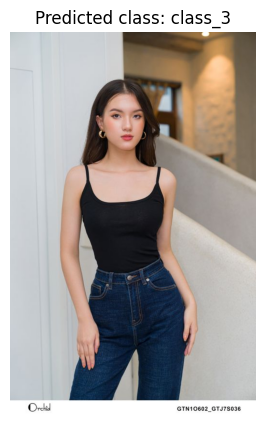

URL: https://pos.nvncdn.com/af3c03-152482/ps/20220618_9iZG4B0JowHfOjEny4DlNwzH.JPG -> Predicted class: class_3
> https://vulcano.sgp1.digitaloceanspaces.com/media/12084/ao_balo_3002w_vulcano-%281%29.jpg


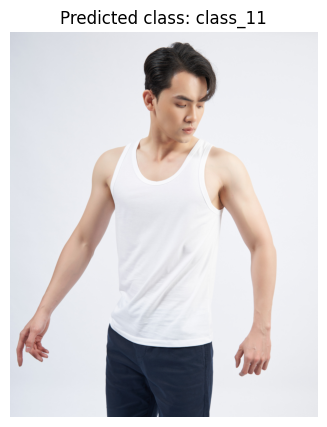

URL: https://vulcano.sgp1.digitaloceanspaces.com/media/12084/ao_balo_3002w_vulcano-%281%29.jpg -> Predicted class: class_11
> https://bizweb.dktcdn.net/100/368/426/products/3070t-1.jpg?v=1696521259460


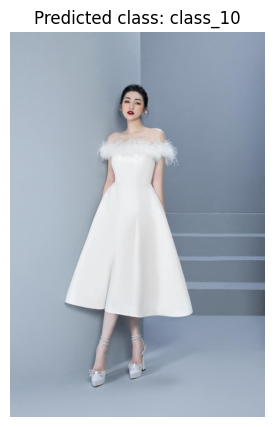

URL: https://bizweb.dktcdn.net/100/368/426/products/3070t-1.jpg?v=1696521259460 -> Predicted class: class_10
> https://bizweb.dktcdn.net/100/368/426/products/vay-cuoi-dai-tiec-ngan-3-jpeg.jpg?v=1678040425840


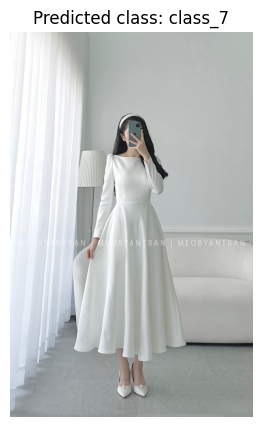

URL: https://bizweb.dktcdn.net/100/368/426/products/vay-cuoi-dai-tiec-ngan-3-jpeg.jpg?v=1678040425840 -> Predicted class: class_7
> https://aothun24h.vn/UserFile/editor/ao-thun-tron-form-rong-AT044.jpg
URL: https://aothun24h.vn/UserFile/editor/ao-thun-tron-form-rong-AT044.jpg -> Predicted class: Error loading image from URL: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
> https://aothun24h.vn/UserFile/editor/ao-thun-tron-form-rong-AT044.jpg
URL: https://aothun24h.vn/UserFile/editor/ao-thun-tron-form-rong-AT044.jpg -> Predicted class: Error loading image from URL: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
> https://aeonmall-review-rikkei.cdn.vccloud.vn/public/image/ecommerce/products/MhvKCd0pUcH8CTSes26a153d7ZI1740hJl85TAR8.jpg


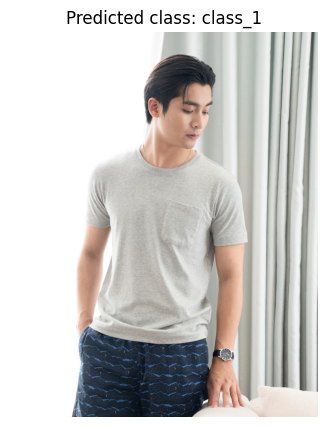

URL: https://aeonmall-review-rikkei.cdn.vccloud.vn/public/image/ecommerce/products/MhvKCd0pUcH8CTSes26a153d7ZI1740hJl85TAR8.jpg -> Predicted class: class_1
> https://pos.nvncdn.com/8073c5-83109/ps/20220401_HHVkXyNr7M4DczuCpQ0hjNVs.jpg


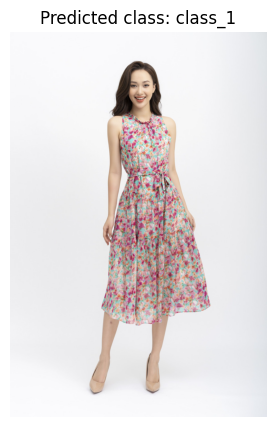

URL: https://pos.nvncdn.com/8073c5-83109/ps/20220401_HHVkXyNr7M4DczuCpQ0hjNVs.jpg -> Predicted class: class_1
> https://heis.vn/storage/uploads/2020/06/13/5ee4f2a11d02a.jpeg


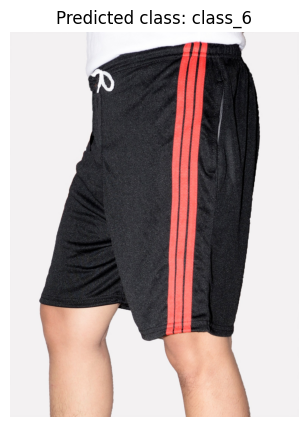

URL: https://heis.vn/storage/uploads/2020/06/13/5ee4f2a11d02a.jpeg -> Predicted class: class_6


In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
from PIL import Image
import requests
from io import BytesIO
import os
import matplotlib.pyplot as plt
import numpy as np

# Thiết lập các tham số
NUM_CLASSES = 13
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform cho ảnh đầu vào
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Hàm tải model
def load_model(model_path):
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()
    return model

# Hàm dự đoán cho một ảnh
def predict_image(model, image, class_names):
    image = test_transforms(image)
    image = image.unsqueeze(0)  # Thêm batch dimension
    image = image.to(DEVICE)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

# Hàm dự đoán và hiển thị ảnh từ URL
def predict_image_from_url(model, url, class_names):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Kiểm tra lỗi HTTP
        image = Image.open(BytesIO(response.content)).convert('RGB')

        # Dự đoán
        predicted_class = predict_image(model, image, class_names)

        # Hiển thị ảnh
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Predicted class: {predicted_class}")
        plt.show()

        return predicted_class
    except Exception as e:
        return f"Error loading image from URL: {str(e)}"

# Hàm dự đoán cho ảnh từ file cục bộ
def predict_image_from_file(model, image_path, class_names):
    try:
        image = Image.open(image_path).convert('RGB')
        predicted_class = predict_image(model, image, class_names)

        # Hiển thị ảnh
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Predicted class: {predicted_class}")
        plt.show()

        return predicted_class
    except Exception as e:
        return f"Error loading image from file: {str(e)}"

# Hàm dự đoán cho nhiều ảnh trong thư mục
def predict_folder(model, folder_path, class_names):
    predictions = []
    for img_name in os.listdir(folder_path):
        if img_name.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, img_name)
            predicted_class = predict_image_from_file(model, img_path, class_names)
            predictions.append((img_name, predicted_class))
    return predictions

# Hàm chính
def main():
    # Đường dẫn đến file model
    model_path = "/content/best_model.pth"

    class_names = None
    train_dir = "/content/dataset/eff_dataset/train"
    if os.path.exists(train_dir):
        class_names = sorted(os.listdir(train_dir))
    else:
        class_names = [f"class{i}" for i in range(1, NUM_CLASSES + 1)]
        print("Warning: train directory not found. Using default class names:", class_names)

    model = load_model(model_path)

    print("Nhập URL ảnh hoặc đường dẫn file/thư mục (nhập 'exit' để thoát):")
    while True:
        user_input = input("> ").strip()
        if user_input.lower() == 'exit':
            break

        # Kiểm tra input là URL, file hay folder
        if user_input.startswith(('http://', 'https://')):
            predicted_class = predict_image_from_url(model, user_input, class_names)
            print(f"URL: {user_input} -> Predicted class: {predicted_class}")
        elif os.path.isfile(user_input):
            predicted_class = predict_image_from_file(model, user_input, class_names)
            print(f"Image: {user_input} -> Predicted class: {predicted_class}")
        elif os.path.isdir(user_input):
            predictions = predict_folder(model, user_input, class_names)
            for img_name, predicted_class in predictions:
                print(f"Image: {img_name} -> Predicted class: {predicted_class}")
        else:
            print("Error: Input must be a valid image file, folder path, or URL.")

if __name__ == "__main__":
    main()

In [11]:
!cp /content/best_model.pth /content/drive/MyDrive/DoAnCV/best_cnn.pth